In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import torch
import os.path
sys.path.insert(1, '../')
import topovelo as tpv
import matplotlib.pyplot as plt
from scipy.io import mmread, mmwrite
from numpy import savetxt
%load_ext autoreload
%autoreload 2

In [2]:
root = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/slide-seq/adult_cortex'
dataset = 'slide-seq-adult-cortex'
data_path_base = f'/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/{dataset}'
figure_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/{dataset}'
model_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/checkpoints/{dataset}'

# Integrate data into a single .h5ad file

In [5]:
U = mmread(f'{root}/velo_u.mtx').tocsr()
S = mmread(f'{root}/velo_s.mtx').tocsr()
X = mmread(f'{root}/dge_raw.mtx').tocsr()

In [6]:
df_cluster = pd.read_csv(f'{root}/clusters.csv', header=None, index_col=0)
df_pos = pd.read_csv(f'{root}/cell_locations.csv')
df_gene = pd.read_csv(f'{root}/genes.csv', header=None, index_col=0)

In [7]:
print(df_cluster.head())
print(df_pos.head())
print(df_gene.head())

                 1
0                 
AATAGGTGCTCGAN  VZ
ACTCGCTGTAATTC  VZ
AGCGGAGCGATCAA  VZ
ATTTTTTAGATCGA  VZ
CAACAAATTATCCG  VZ
                       x         y
AATAGGTGCTCGAN  0.670171  0.877913
ACTCGCTGTAATTC  0.675054  0.952051
AGCGGAGCGATCAA  0.634527  1.315455
ATTTTTTAGATCGA  0.720889  0.835830
CAACAAATTATCCG  0.607203  0.819411
Empty DataFrame
Columns: []
Index: [0610007P14Rik, 0610009B22Rik, 0610009E02Rik, 0610009L18Rik, 0610009O20Rik]


In [8]:
adata = anndata.AnnData(X=X.T,
                        obs=df_cluster,
                        var=df_gene,
                        layers={'unspliced':U.T, 'spliced':S.T})

In [15]:
adata.obsm['X_spatial'] = df_pos[['x', 'y']].values

In [16]:
adata.obs.index = adata.obs.index.set_names('barcode')
adata.obs = adata.obs.rename(columns={1: 'clusters'})
adata.obs.head()

,clusters
barcode,
AATAGGTGCTCGAN,VZ
ACTCGCTGTAATTC,VZ
AGCGGAGCGATCAA,VZ
ATTTTTTAGATCGA,VZ
CAACAAATTATCCG,VZ


In [11]:
adata.var.index = adata.var.index.set_names('gene')

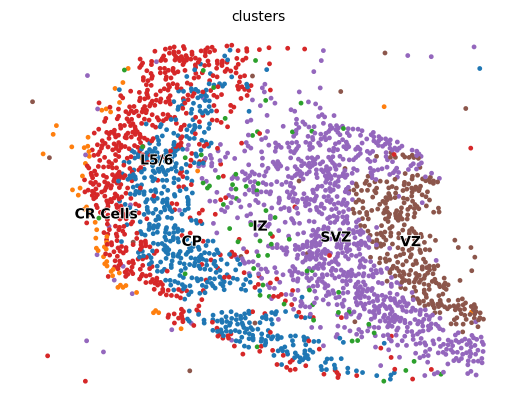

In [19]:
scv.pl.scatter(adata, basis='spatial')

In [18]:
adata.write_h5ad(f'{root}/{dataset}.h5ad')

# Preprocessing

In [6]:
adata = anndata.read_h5ad(f'{root}/{dataset}.h5ad')

In [7]:
tpv.preprocess(adata,
               n_gene=200,
               spatial_key='X_spatial',
               spatial_smoothing=True,
               min_count_per_cell=1,
               min_genes_expressed=1,
               compute_umap=True)

Filtered out 9533 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 200 highly variable genes.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.
Computing UMAP coordinates.
Computing spatial KNN graph.
Spatial KNN smoothing


In [22]:
adata.write_h5ad(f'{root}/{dataset}_pp_hg.h5ad')

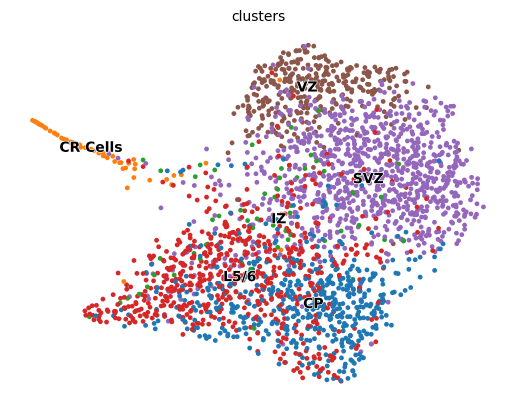

In [8]:
scv.pl.scatter(adata)

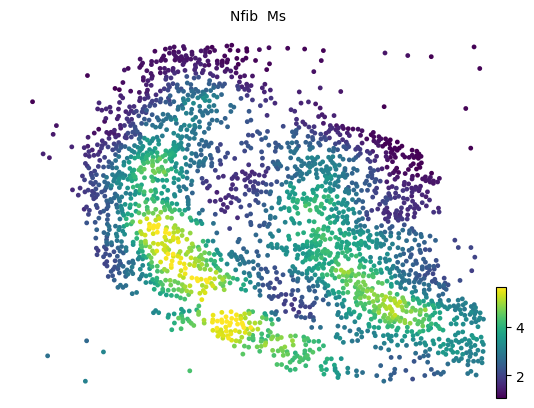

In [9]:
scv.pl.scatter(adata, layer='Ms', color=['Nfib'], basis='spatial')

## Train Model

In [34]:
adata = anndata.read_h5ad(f'{root}/{dataset}_pp_hg.h5ad')

In [24]:
x = -adata.obsm['X_pos'][:, 0]
tprior = 20 * (x - x.min())/(x.max() - x.min())
adata.obs['tprior'] = tprior

In [55]:
# Optional: load a Delauney triangulation graph
graph = mmread(f'{root}/DT_nn_graph.mtx').tocsr().T
adata.var['median_s'] = np.median(adata.layers['Ms'], 0)
adata.var['median_u'] = np.median(adata.layers['Mu'], 0)
gene_plot = tpv.sample_genes(adata, 4, 'median_s')
print(gene_plot)

['Map1b' 'Nfib' 'Basp1' 'Stmn2']


In [10]:
figure_path = f'{figure_path_base}/tpv'
model_path = f'{model_path_base}/tpv'
vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 50),
              device='cuda:0',
              graph_decoder=True,
              attention=False,
              reverse_gene_mode=False,
              std_z_prior=1e-2)

config = {
    
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          'X_spatial',
          config=config,
          plot=False,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'tpv', data_path_base, file_name="adata_out_knn30.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Detected 83 velocity genes.
Estimating the variance...


  0%|          | 0/200 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.40, 0.6766444682941929), (0.60, 0.3127072543251332)
(0.48, 0.7100675095737389), (0.52, 0.28915982867281675)
(0.65, 0.7493282561972415), (0.35, 0.32424596675700534)
KS-test result: [0. 0. 0.]
Initial induction: 95, repression: 105/200
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0004
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 645.       *********
Summary: 
Train ELBO = 303.422
Test ELBO = 257.539
Total Time =   0 h :  2 m : 17 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/2525 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.049
Average Neighborhood Size: 57.7
Average Set Size: 14.7
Summary: 
Train ELBO = 417.134
Test ELBO = 426.181
Total Time =   0 h :  2 m : 37 s

*********       Round 1: Early Stop Triggered at epoch 755.       *********
Change in noise variance: 0.1690
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 444.675
Test ELBO = 435.064
Total Time =   0 h :  2 m : 49 s

*********       Round 2: Early Stop Triggered at epoch 830.       *********
Change in noise variance: 0.0016
Change in x0: 0.3991
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 431.363
Test ELBO = 431.938
Total Time =   0 h :  2 m : 53 s

*********       Round 3: Early Stop Triggered at epoch 858.       *********
Change in noise variance: 0.0003
Change in x0: 0.2170
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 418.553
Test ELBO = 426.512
Total Time =   0 

# Graph Attention

In [11]:
figure_path = f'{figure_path_base}/gat'
model_path = f'{model_path_base}/gat'

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 50),
              device='cuda:0',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=False,
              std_z_prior=1e-2)

config = {
    
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          'X_spatial',
          config=config,
          plot=False,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder_gat', 'decoder_gat')
vae.save_anndata(adata, 'gat', data_path_base, file_name="adata_out_knn30.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Detected 83 velocity genes.
Estimating the variance...


  0%|          | 0/200 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.40, 0.6766444682941929), (0.60, 0.3127072543251332)
(0.48, 0.7100675095737389), (0.52, 0.28915982867281675)
(0.65, 0.7493282561972415), (0.35, 0.32424596675700534)
KS-test result: [0. 0. 0.]
Initial induction: 95, repression: 105/200
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0004
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 385.       *********
Summary: 
Train ELBO = 309.744
Test ELBO = 308.185
Total Time =   0 h :  3 m :  5 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/2525 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.036
Average Neighborhood Size: 57.7
Average Set Size: 16.1
Summary: 
Train ELBO = 468.495
Test ELBO = 460.311
Total Time =   0 h :  3 m : 25 s

*********       Round 1: Early Stop Triggered at epoch 426.       *********
Change in noise variance: 0.1914
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 472.839
Test ELBO = 462.332
Total Time =   0 h :  3 m : 52 s

*********       Round 2: Early Stop Triggered at epoch 495.       *********
Change in noise variance: 0.0003
Change in x0: 0.2257
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 455.007
Test ELBO = 457.271
Total Time =   0 h :  3 m : 59 s

*********       Round 3: Early Stop Triggered at epoch 512.       *********
Change in noise variance: 0.0000
Change in x0: 0.1855
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 460.364
Test ELBO = 448.563
Total Time =   0 

In [ ]:
G = vae.decoder.n_gene
condition = (F.one_hot(vae.graph_data.batch, vae.n_batch).float()
                        if vae.enable_cvae else None)
scaling_u = vae.decoder.get_param_1d('scaling_u', condition, sample=False, detach=False)
scaling_s = vae.decoder.get_param_1d('scaling_s', condition, sample=False, detach=False)
data_in_scale = torch.cat((vae.graph_data.data.x[:, :G]/scaling_u,
                           vae.graph_data.data.x[:, G:]/scaling_s), 1)

mu_t, std_t, mu_z, std_z = vae.encoder.forward(vae.graph_data.data.x,
                                               vae.graph_data.data.adj_t,
                                               vae.graph_data.edge_weight,
                                               condition)

t = vae.sample(mu_t, std_t)
z = vae.sample(mu_z, std_z)
gatconv = vae.decoder.net_rho2.conv1
h, att = gatconv(z,
                 vae.graph_data.data.adj_t,
                 vae.graph_data.edge_weight,
                 return_attention_weights=True)
h1 = vae.decoder.net_rho2.act(h)
if condition is not None:
    h2 = torch.cat((h1, condition), 1)
if not vae.decoder.net_rho2.enable_sigmoid:
    rho = vae.decoder.net_rho2.fc_out(h2)
else:
    rho = vae.decoder.net_rho2.sigm(vae.decoder.net_rho2.fc_out(h2))

In [85]:
row, col, val = att.cpu().csr()

In [97]:
nbs = torch.where(col == 0)[0]
att_score = val[nbs]

In [101]:
vae.graph_data.data.x.requires_grad = True

In [103]:
vae.graph_data.data.x[nbs].requires_grad

True

In [115]:
idx = np.where(adata.var_names=='Nfib')[0][0]
gd = torch.autograd.grad(rho[0, idx], vae.graph_data.data.x, retain_graph=True, allow_unused=True)

In [116]:
print(gd)

(None,)


# VeloVAE

In [39]:
adata = anndata.read_h5ad(f'{data_path_base}/adata_out_knn30.h5ad')

In [4]:
sys.path.insert(1, '../../velovae')
import velovae as vv

In [6]:
figure_path = f'{figure_path_base}/vv'
model_path = f'{model_path_base}/vv'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 25, 50),
              device='cuda:0',
              reverse_gene_mode=False)
config = {
    #'early_stop_thred': 1.0
}
vae.train(adata, config=config, plot=False, figure_path=figure_path, embed='pos')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'vv', data_path_base, file_name="adata_out.h5ad")

Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Detected 49 velocity genes.
Estimating the variance...


  0%|          | 0/200 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.45, 0.26436819265956807), (0.55, 0.6699464796599823)
(0.65, 0.7300036933460016), (0.35, 0.23797667413812668)
KS-test result: [0. 2. 0.]
Initial induction: 95, repression: 105/200
Learning Rate based on Data Sparsity: 0.0004
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 14, test iteration: 26
*********       Stage 1: Early Stop Triggered at epoch 511.       *********
*********                      Stage  2                       *********
*********  

  0%|          | 0/2525 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.032
Average Set Size: 50
*********     Round 1: Early Stop Triggered at epoch 710.    *********
Change in noise variance: 0.2041
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 725.    *********
Change in noise variance: 0.0004
Change in x0: 0.2968
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 733.    *********
Change in noise variance: 0.0000
Change in x0: 0.2143
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 752.    *********
Change in noise variance: 0.0000
Change in x0: 0.2018
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 875.    *********
Change in noise variance: 0.0000
Change in x0: 0.2049
*********             Velocity Refinement Round 6    

In [7]:
figure_path = f'{figure_path_base}/vv'
model_path = f'{model_path_base}/vv'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             hidden_size=(50, 25, 25, 50),
             device='cuda:0',
             full_vb=True,
             reverse_gene_mode=False)
config = {
    #'early_stop_thred': 1.0
}
vae.train(adata, config=config, plot=False, figure_path=figure_path, embed='pos')
vae.save_model(model_path, 'encoder_fullvb', 'decoder_fullvb')
vae.save_anndata(adata, 'fullvb', data_path_base, file_name='adata_out.h5ad')

Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Detected 49 velocity genes.
Estimating the variance...


  0%|          | 0/200 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.45, 0.26436819265956807), (0.55, 0.6699464796599823)
(0.65, 0.7300036933460016), (0.35, 0.23797667413812668)
KS-test result: [0. 2. 0.]
Initial induction: 95, repression: 105/200
Learning Rate based on Data Sparsity: 0.0004
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 14, test iteration: 26
*********       Stage 1: Early Stop Triggered at epoch 625.       *********
*********                      Stage  2                       *********
*********  

  0%|          | 0/2525 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 50
*********     Round 1: Early Stop Triggered at epoch 761.    *********
Change in noise variance: 0.2005
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 793.    *********
Change in noise variance: 0.0002
Change in x0: 0.3268
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 801.    *********
Change in noise variance: 0.0000
Change in x0: 0.2833
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 839.    *********
Change in noise variance: 0.0000
Change in x0: 0.2658
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 873.    *********
Change in noise variance: 0.0000
Change in x0: 0.2467
*********             Velocity Refinement Round 6    

# scVelo

In [3]:
adata = anndata.read_h5ad(f"{data_path_base}/adata_out_knn30.h5ad")

In [16]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

recovering dynamics (using 1/32 cores)


  0%|          | 0/150 [00:00<?, ?gene/s]

    finished (0:00:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/2525 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 5 regions of root cells and 6 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [6]:
adata.write_h5ad(f"{data_path_base}/adata_out.h5ad")

In [70]:
adata.layers['Mu'] = adata.layers['Mu_sp']
adata.layers['Ms'] = adata.layers['Ms_sp']

['Map2']
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/2525 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/slide-seq-adult-cortex/cortex_knn50_fit.png


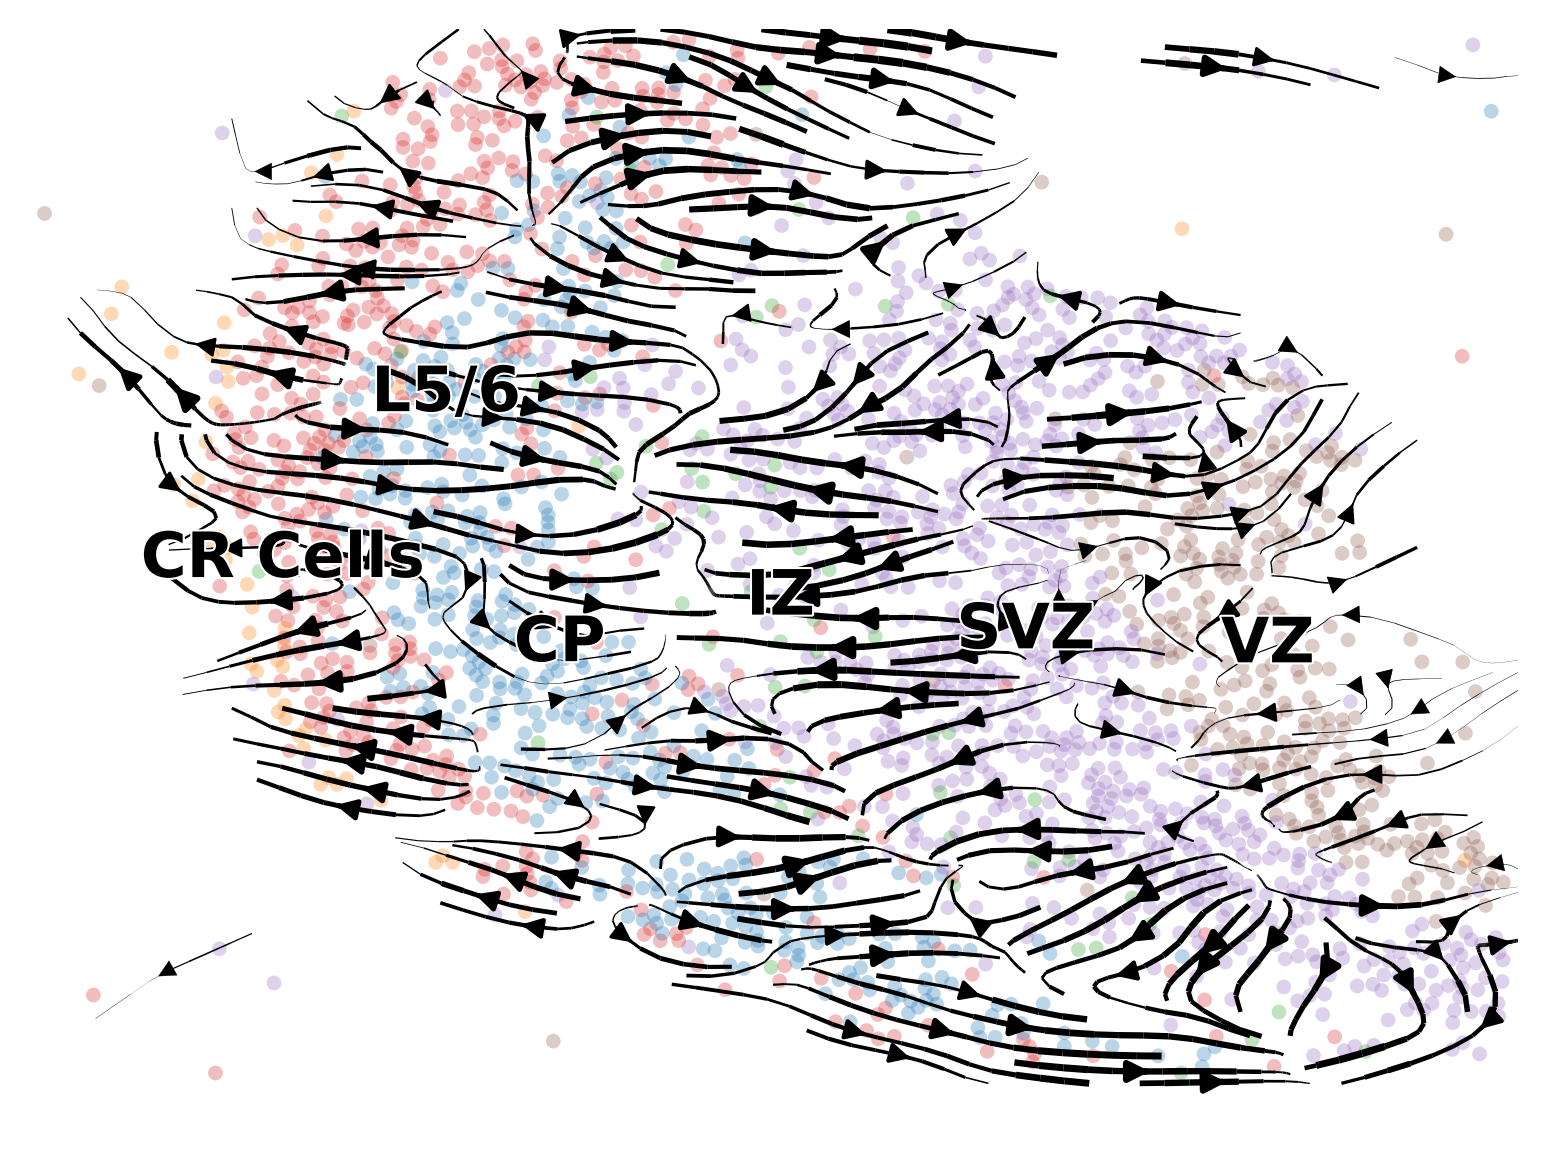

In [17]:
(res, res_type,
 multi_res, multi_res_type) = tpv.post_analysis(adata,
                                                'cortex_knn50',
                                                ['scVelo'],
                                                ['fit'],
                                                spatial_velocity_graph=True,
                                                spatial_graph_key='spatial_graph',
                                                spatial_key='X_spatial',
                                                compute_metrics=False,
                                                embed='spatial',
                                                plot_type=['stream'],
                                                dpi=300,
                                                figure_path=figure_path_base)

['Map2']
---   Plotting  Results   ---


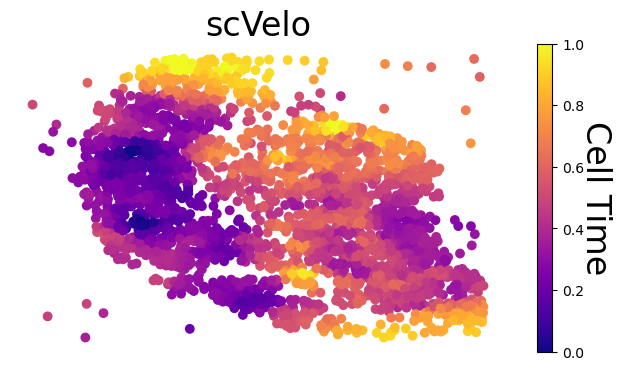

In [18]:
(res, res_type,
 multi_res, multi_res_type) = tpv.post_analysis(adata,
                                                'cortex',
                                                ['scVelo'],
                                                ['fit'],
                                                spatial_velocity_graph=True,
                                                spatial_graph_key='spatial_graph',
                                                spatial_key='X_spatial',
                                                compute_metrics=False,
                                                embed='spatial',
                                                plot_type=['time'],
                                                dpi=300,
                                                figure_path=figure_path_base)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
res.loc[['corr', 'Spatial Consistency'], :].T.plot.bar(ax=ax, subplots=True, fontsize=16, rot=0)
plt.tight_layout()
fig.savefig(f"{figure_path_base}/perf.png")

In [49]:
adata.obsp

PairwiseArrays with keys: connectivities, distances, spatial_graph